### Importing libraries

In [378]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

### Ingesting Data

In [379]:
train = pd.read_csv('datasets/train.csv', index_col='Id')
test =  pd.read_csv('datasets/test.csv', index_col='Id')
#data = pd.concat([train, test])
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [380]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Data Exploration

In [381]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [382]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Variable Distribution

In [383]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [384]:
# grid = sns.FacetGrid(train)
# grid.map_dataframe(sns.histplot)
# plt.savefig('histograms.jpg')

## Missing Data

In [385]:
def check_missing(df=train):
    missing = df.isna().sum()
    missing_data = missing[missing > 0]
    return missing_data

check_missing()

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

<Axes: >

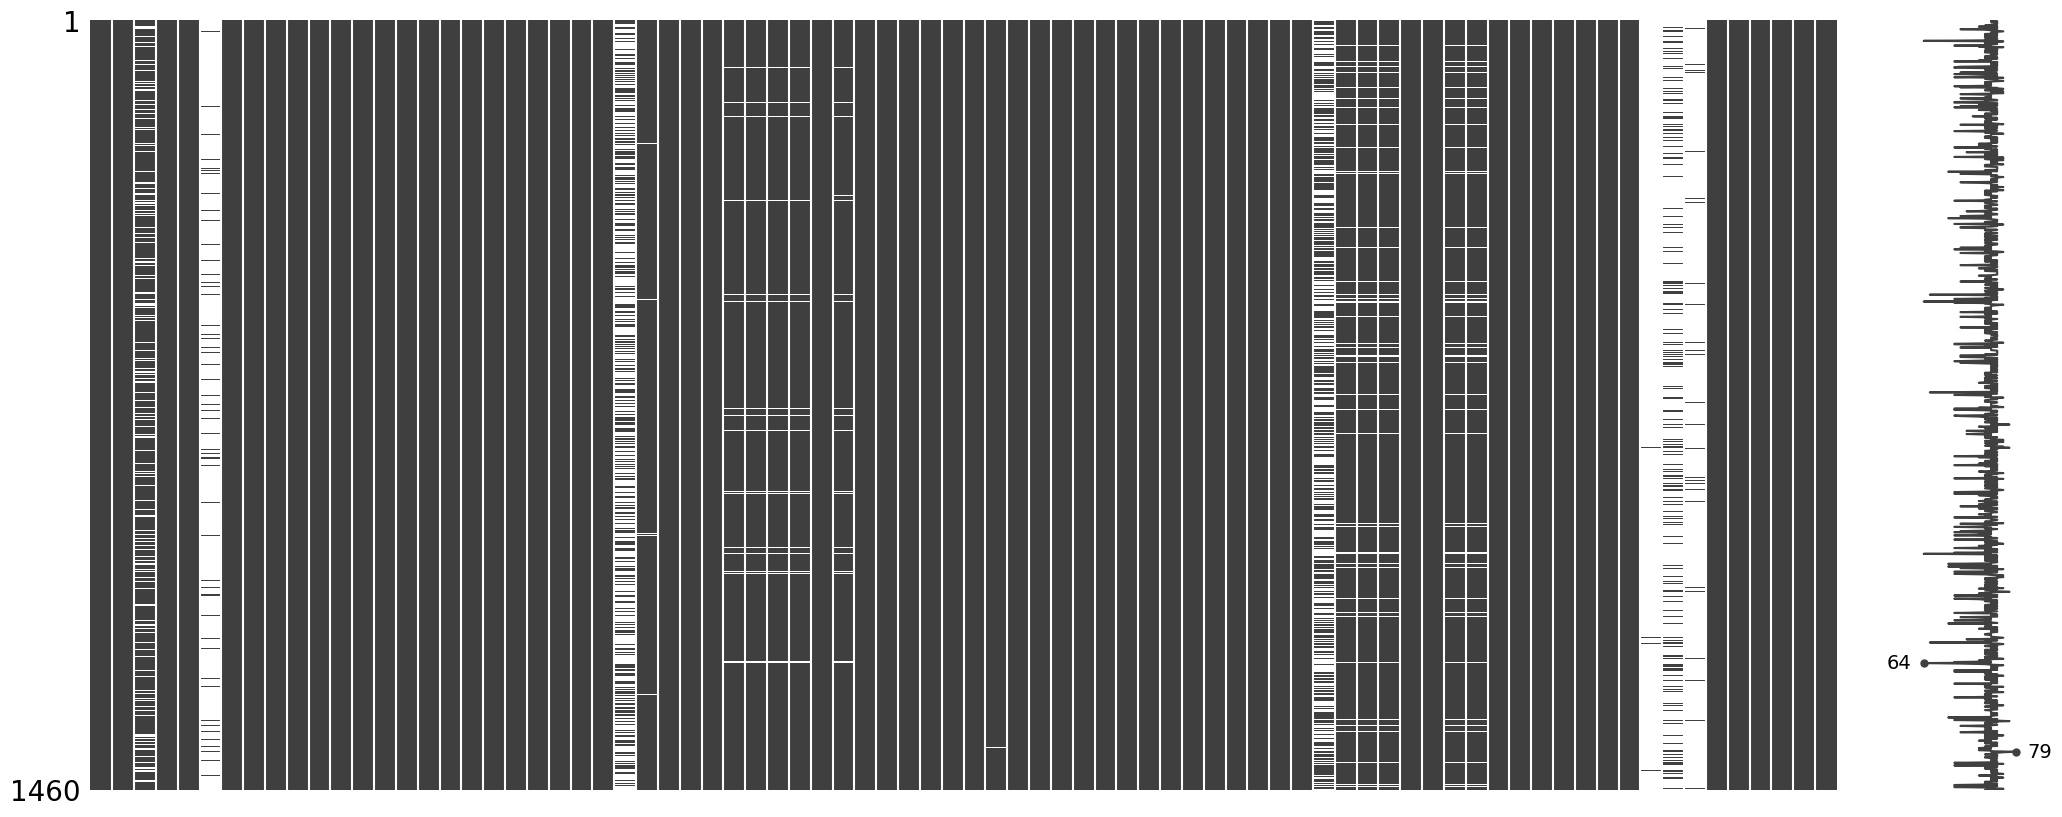

In [386]:
msno.matrix(train)

<Axes: >

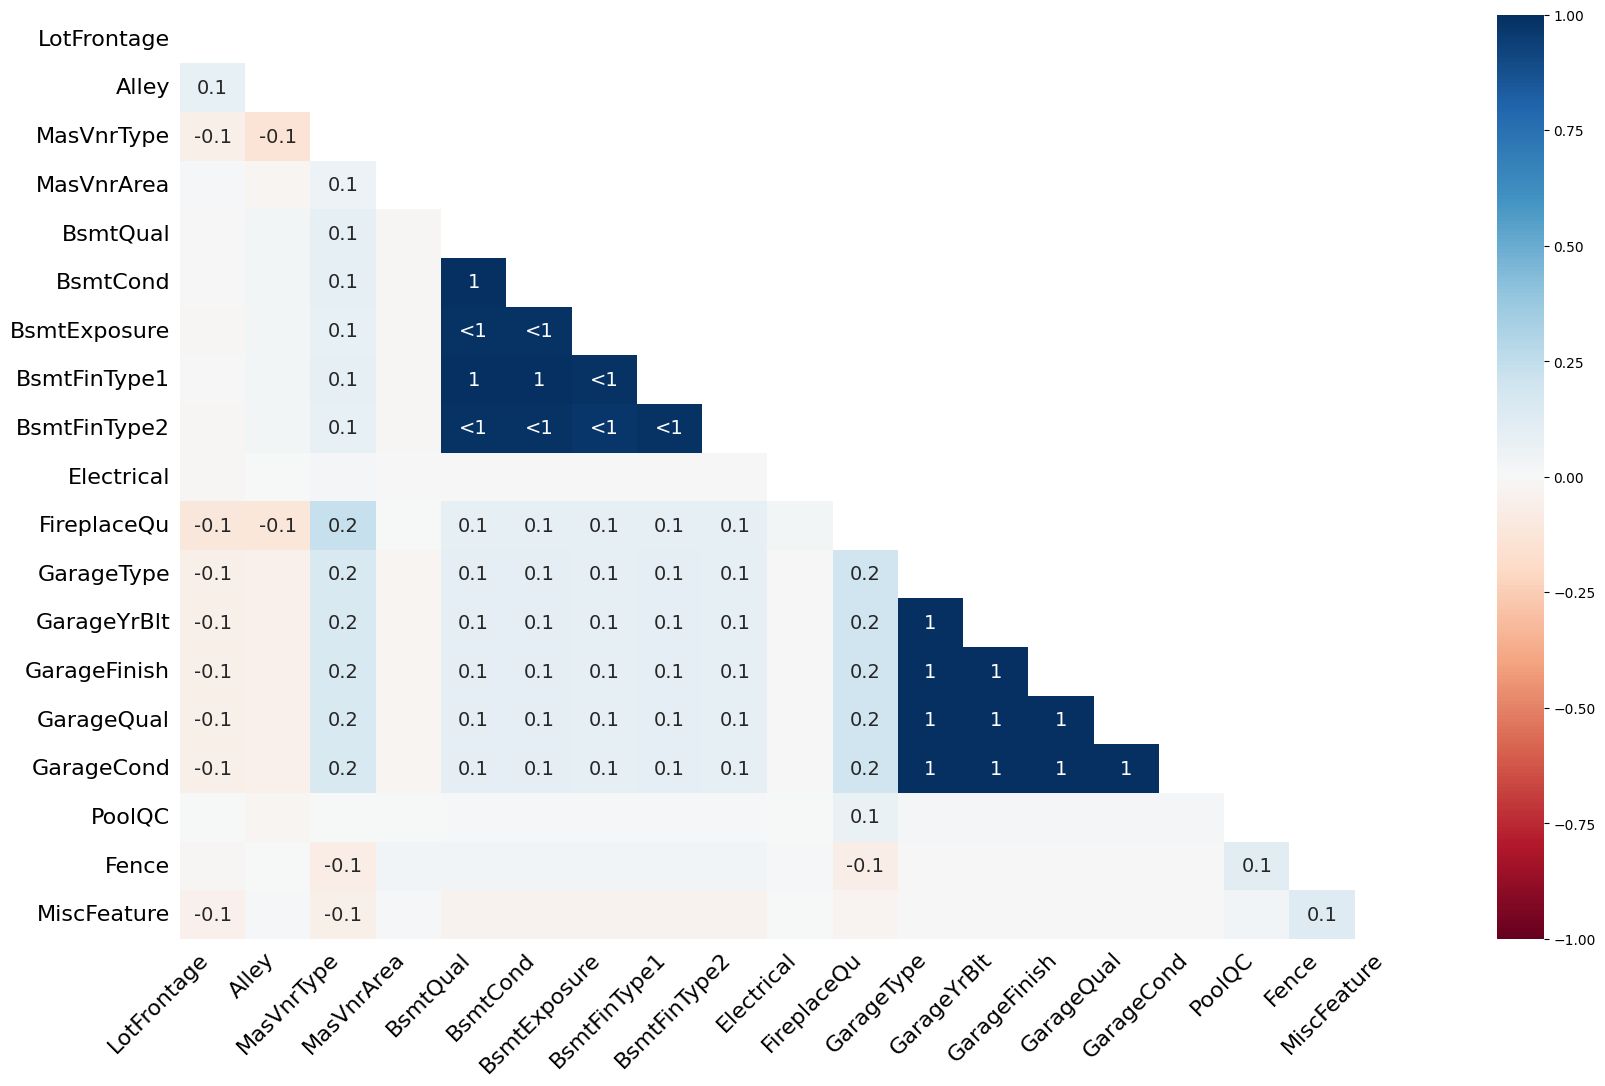

In [387]:
msno.heatmap(train)

# Fill Missing Data

### YearBuilt

In [388]:
corr = train[["GarageYrBlt", "YearBuilt"]].corr()
corr

,GarageYrBlt,YearBuilt
GarageYrBlt,1.000000,0.825667
YearBuilt,0.825667,1.000000


In [389]:
train["GarageYrBlt"].fillna(train["YearBuilt"],inplace=True)

## LotFrontage

In [390]:
check_missing()

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

c:\Users\gylbt\anaconda3\envs\ml.venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


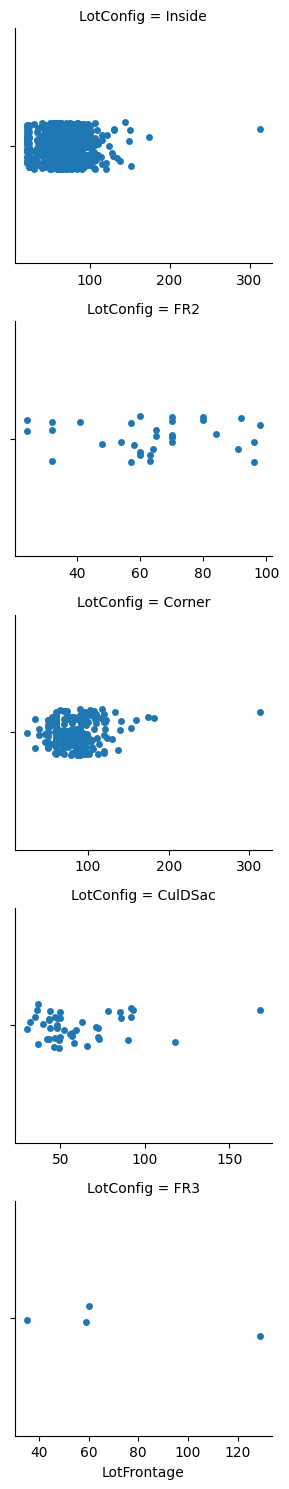

In [391]:
sns.catplot(data=train, x='LotFrontage',kind='strip', row='LotConfig', sharex=False,height=3,orient='portrait')

plt.show()


In [392]:
lot_front_dic = train.mask(train.LotFrontage.isna()) \
            .groupby('LotConfig') \
                ['LotFrontage'].median().round() \
                .to_dict()

lot_front_dic

{'Corner': 80.0, 'CulDSac': 50.0, 'FR2': 64.0, 'FR3': 60.0, 'Inside': 68.0}

In [393]:
missing_LF = train[train.LotFrontage.isna()].index  

for key, item in lot_front_dic.items():
    train.loc[train['LotConfig']== key, 'LotFrontage'].fillna(item, inplace=True)

In [394]:
check_missing()

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

# Drop Columns

### Drop 8 rows of ManVnrArea

In [395]:
train.dropna(axis = 'rows', subset=["MasVnrArea"], inplace=True)

### Drop categorical columns  with more than 600 missing values

In [396]:
t = int(train.shape[0]*.90)
train.dropna(axis='columns', thresh= t, inplace=True)

### Drop Columns Dominated by a certain value

In [397]:
unbalanced_cols = []
for col in train.select_dtypes('object').columns:
    value_counts = train[col].value_counts(normalize=True)

    max = value_counts.max()
    
    print(value_counts)
   # print(max)

    if max > .70:
        unbalanced_cols.append(col)


MSZoning
RL         0.789256
RM         0.150138
FV         0.042700
RH         0.011019
C (all)    0.006887
Name: proportion, dtype: float64
Street
Pave    0.995868
Grvl    0.004132
Name: proportion, dtype: float64
LotShape
Reg    0.632920
IR1    0.331956
IR2    0.028237
IR3    0.006887
Name: proportion, dtype: float64
LandContour
Lvl    0.897383
Bnk    0.043388
HLS    0.034435
Low    0.024793
Name: proportion, dtype: float64
Utilities
AllPub    0.999311
NoSeWa    0.000689
Name: proportion, dtype: float64
LotConfig
Inside     0.720386
Corner     0.180441
CulDSac    0.064050
FR2        0.032369
FR3        0.002755
Name: proportion, dtype: float64
LandSlope
Gtl    0.946281
Mod    0.044766
Sev    0.008953
Name: proportion, dtype: float64
Neighborhood
NAmes      0.154959
CollgCr    0.102617
OldTown    0.077824
Edwards    0.068871
Somerst    0.057163
Gilbert    0.053719
NridgHt    0.052342
Sawyer     0.050964
NWAmes     0.050275
SawyerW    0.039945
BrkSide    0.039945
Crawfor    0.034435
M

In [398]:
train.drop(unbalanced_cols,axis='columns',inplace=True)
check_missing()

BsmtQual        37
BsmtExposure    38
BsmtFinType1    37
GarageType      81
GarageFinish    81
dtype: int64

In [399]:
train.dropna(axis=0,inplace=True)
print(train.shape)
check_missing()

(1340, 50)


Series([], dtype: int64)

In [401]:
y_train = train.pop('SalePrice')
x_train = train
check_missing(train_final)

Series([], dtype: int64)

## Feature selection with scikit-learn

In [403]:
from sklearn.feature_selection import f_regression, r_regression

coeff = r_regression(x_train.select_dtypes(exclude='object').dropna(), y_train)
coeff

array([-0.08043069,  0.25461901,  0.78371206, -0.10894618,  0.50430152,
        0.50141952,  0.46633041,  0.36055697, -0.02870014,  0.19339048,
        0.6000715 ,  0.6050561 ,  0.31018221, -0.01006291,  0.71147042,
        0.21057856, -0.03034053,  0.56929343,  0.25687453,  0.16929042,
       -0.11146632,  0.55167166,  0.44563924,  0.48173202,  0.64061078,
        0.60814233,  0.30501514,  0.3219279 , -0.12755632,  0.04204588,
        0.09635248,  0.09177367, -0.01704208,  0.04259315, -0.01963343])

## Drop highly correlated independent variables

In [307]:
to_drop = corr_df.query('OverallCond >-.80 and OverallCond >.80').index.tolist()
to_drop.append('OverallQual')
train.drop(columns=to_drop, inplace=True)
train

,MSSubClass,LotArea,LotShape,Neighborhood,HouseStyle,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,Reg,CollgCr,2Story,2003,2003,VinylSd,VinylSd,196.0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,9600,Reg,Veenker,1Story,1976,1976,MetalSd,MetalSd,0.0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,11250,IR1,CollgCr,2Story,2001,2002,VinylSd,VinylSd,162.0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,9550,IR1,Crawfor,2Story,1915,1970,Wd Sdng,Wd Shng,0.0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,14260,IR1,NoRidge,2Story,2000,2000,VinylSd,VinylSd,350.0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,7917,Reg,Gilbert,2Story,1999,2000,VinylSd,VinylSd,0.0,...,0,40,0,0,0,0,0,8,2007,175000
1457,20,13175,Reg,NWAmes,1Story,1978,1988,Plywood,Plywood,119.0,...,349,0,0,0,0,0,0,2,2010,210000
1458,70,9042,Reg,Crawfor,2Story,1941,2006,CemntBd,CmentBd,0.0,...,0,60,0,0,0,0,2500,5,2010,266500


In [308]:
# str_cols = train.select_dtypes('object').columns.to_list()

# for col in str_cols:
#     bools= train[col].str.contains('\d\d')
#     if bools.sum() > 0:
#         print(col)

# Modeling

## Imports

In [309]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score


## Preprocessing Pipeline

In [310]:
import regex as re

def scale_encode(df: pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler() 
   # encoder = OneHotEncoder() 
    
    X_num = df.select_dtypes(exclude='object')  
                                                                 
    X_scaled = scaler.fit_transform(X_num) 

    #X_encoded = pd.get_dummies(df, prefix='enc_') 

   # X_dummies= X_encoded.filter(regex='enc_', axis=1) 

    X_final = pd.DataFrame(X_scaled,columns=X_num.columns.to_list(), index=X_num.index)#.join(X_dummies)

    return X_final

    


In [311]:
train_final = scale_encode(train)
y_train = train_final.pop('SalePrice')
x_train = train_final
check_missing(train_final)

Series([], dtype: int64)

# Baseline Model (Linear Regression)    

In [312]:
linear_reg = LinearRegression()

linear_reg.fit(x_train, y_train)

LinearRegression()

In [313]:
for col in test.columns:
    if col not in x_train.columns:
        test.drop(axis='column', columns=col, inplace=True)


In [314]:
X_test_final = scale_encode(test)
check_missing(X_test_final)

MasVnrArea      15
BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
GarageYrBlt     78
GarageCars       1
GarageArea       1
dtype: int64

In [315]:
X_test_final.dropna(inplace=True)
y_pred = linear_reg.predict(X_test_final)
pd.Series(y_pred).to_csv('submission.csv')

In [316]:
# R2 = linear_reg.score(X_test_final, y_test)
# print(f"The R^2 value for this model is : {R2}")

# residuals = y_test-y_pred
# plt.hist(residuals)
# plt.show()

In [317]:
# y_pred_m = np.maximum(0, y_pred)
# plt.plot(y_test)
# plt.plot(y_pred)
# plt.show()

# Baseline Model (Decision Tree)

In [318]:
dt = DecisionTreeRegressor(criterion='squared_error')

dt.fit(x_train, y_train)

DecisionTreeRegressor()

In [319]:
dt.feature_names_in_

array(['MSSubClass', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'], dtype=object)

In [320]:
dt.predict(X_test_final)

array([-1.16733496, -0.40343845, -0.02307505, ..., -1.17050465,
       -0.08012956,  0.48407616])